# 🍿 Final Project - The Movie Database

## Introduction 

Is money strong enough to determine profitability, popularity and public appreciation of movies?  
Are movies so plain that one may guess their genres with only their overview? 

For this project, we have targeted movies to analyze them and predict:
- A budget a movie must be allocated, to achieve a certain amount of revenue, public appreciation and popularity (Numerical);
- And the single or multiple genres of a movie, by providing its text overview (Textual).

This project uses the TMDB API but is not endorsed or certified by TMDB.

Imports we will be using for the project

In [19]:
import requests
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
import spacy
import spacy.cli

from transformers import AutoTokenizer, AutoModel

In [20]:
# For BERT embeddings
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
# Download the language model, that includes tokenization, part-of-speech tagging, and lemmatization
SPACY_MODEL="fr_core_news_md"
spacy.cli.download(SPACY_MODEL)

## How did we collect the data?
> The Movie Database (TMDB) is a public API which provides lot of data about movies, series and TV shows, including descriptions, title, ratings, and more.

In [24]:
DATA_LANGUAGE="fr-FR"
API_KEY = input("Enter your API key: ")

For safety, we will verify whether the entered API_KEY is correct.  

In [ ]:
# Throw error if API_KEY is incorrect
try:
    if not API_KEY:
        raise ValueError("no API_KEY provided")
    url = "https://api.themoviedb.org/3/authentication"
    headers = {"accept": "application/json", "Authorization": f"Bearer {API_KEY}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
except Exception as e:
    raise ValueError(
        "API_KEY is not set or invalid. Please provide a valid API key."
    ) from e

We need to get the IDs of the movies we'd like to collect.  

TMDB uses a system of pages, where each page contains a list of movies.  
We will fetch the data with API requests in French. 

In [ ]:
def get_full_array(page):
    try:
        url = f"https://api.themoviedb.org/3/discover/movie?language={DATA_LANGUAGE}&page={page}"
        headers = {
            "accept": "application/json",
            "Authorization": f"Bearer {API_KEY}"
        }

        response = requests.get(url, headers=headers).text
        data = json.loads(response)
        return [movie['id'] for movie in data['results']]
    except Exception as e:
        return []

IDs = []
for page in tqdm(range(1, 501)):
    IDs += get_full_array(page)



100%|██████████| 699/699 [02:48<00:00,  4.16it/s]


In [ ]:
# Display the first 10 movie IDs
IDs[:10] 

[1376434,
 1225916,
 1087891,
 1426776,
 870028,
 552524,
 574475,
 1315988,
 1450599,
 1379587]

After we have collected the movies's ID, we can now get the details of each one in French. 

In [ ]:
data = []
for id in tqdm(range(len(IDs))):
    id = IDs[id]
    url = f"https://api.themoviedb.org/3/movie/{id}?language={DATA_LANGUAGE}"
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    response = requests.get(url, headers=headers).text
    movie = json.loads(response)
    data.append(movie)

100%|██████████| 9999/9999 [18:34<00:00,  8.97it/s]  


We convert the array into `Pandas` dataframe

In [ ]:
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None) # To display all columns
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/a3F9cXjRH488qcOqFmFZwqawBMU.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 28, '...",,1376434,tt36463894,[US],en,Predator: Killer of Killers,Cette anthologie d'animation suit trois des gu...,587.5582,/ts8cZc4u3aIrxmG2HTHXAyQyIPi.jpg,"[{'id': 127928, 'logo_path': '/h0rjX5vjW5r8yEn...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-06-05,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Predator : Killer of Killers,False,8.000,463
1,False,/8CVlB19seZnYVDxGvTK5gU7xj9y.jpg,None,0,"[{'id': 10751, 'name': 'Familial'}, {'id': 12,...",,1225916,None,[BR],pt,3ão: Uma História Sem Fim,,192.4594,/ghNV52iBTQgtkd0nFZkAyvngCbr.jpg,"[{'id': 217455, 'logo_path': None, 'name': 'VC...","[{'iso_3166_1': 'BR', 'name': 'Brazil'}]",2023-12-11,0,150,"[{'english_name': 'Portuguese', 'iso_639_1': '...",Released,,3ão: Uma História Sem Fim,False,9.500,3
2,False,/6van4BavoNXaZhCPdzLHNQ4Uc8H.jpg,None,60000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",,1087891,tt0899043,[US],en,The Amateur,Charlie Heller est un cryptographe génial mais...,527.5350,/gIG2bPJ0E5rxvPWUTpEjw1NE3Su.jpg,"[{'id': 127928, 'logo_path': '/h0rjX5vjW5r8yEn...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-04-09,95956038,123,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Amateur,False,6.913,453
3,False,/wnnu8htEZBLtwrke9QYfLKx6zjp.jpg,None,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",https://www.netflix.com/fr/title/81774713,1426776,tt32550101,[US],en,STRAW,Quel sera le coup de grâce ? Une journée affre...,535.5705,/v5Xsg4NGS4mJ3DpwuN5kUnZxhL3.jpg,"[{'id': 3096, 'logo_path': '/fkZTZ4veYYr3lwr2r...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-06-05,0,105,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,À bout,False,8.151,371
4,False,/yBDvgpyynDsbMyK21FoQu1c2wYR.jpg,"{'id': 870339, 'name': 'Mr. Wolff - Saga', 'po...",80000000,"[{'id': 9648, 'name': 'Mystère'}, {'id': 80, '...",,870028,tt7068946,[US],en,The Accountant²,Christian Wolff est doué pour résoudre les pro...,452.9368,/kgzWQPNZp3byMamRr6Mm1KdgzUl.jpg,"[{'id': 187968, 'logo_path': '/xdVAEg1biNrQw5n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-04-23,102123366,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Mr Wolff 2,False,7.227,748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,False,/3HICibZ3CrwRJg0SQuxx86utf8K.jpg,None,0,"[{'id': 18, 'name': 'Drame'}]",,255882,tt5337374,[KR],ko,소원택시,,2.2552,/xq7BOP1OdMczkIlwJ84wULUGOb7.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2013-10-11,0,117,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,,소원택시,False,4.250,8
9995,False,/213Gdu9zjGsVeWQl6p5gJrBq8n8.jpg,None,0,"[{'id': 18, 'name': 'Drame'}, {'id': 80, 'name...",,74879,tt1827487,"[BA, TR]",tr,Bir Zamanlar Anadolu'da,"Au cœur des steppes d’Anatolie, un meurtrier t...",2.2792,/1VXtCKQeMsH3YdNSaUmsxEFo43z.jpg,"[{'id': 75040, 'logo_path': '/mAK4Bw5CC6AUUmRU...","[{'iso_3166_1': 'BA', 'name': 'Bosnia and Herz...",2011-09-23,138730,150,"[{'english_name': 'Turkish', 'iso_639_1': 'tr'...",Released,,Il était une fois en Anatolie,False,7.479,497
9996,False,/1irKMWD434k8nCjn4l5qda7gc4q.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",,758902,tt12151820,[CN],zh,侍神令,"Quand un conflit éclate entre royaumes, Qing M...",1.9295,/eNjSXnsawGd9QjrFBX20jE1lVh2.jpg,"[{'id': 89365, 'logo_path': None, 'name': 'CKF...","[{'iso_3166_1': 'CN', 'name': 'China'}]",2021-02-12,0,113,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,,The Yin-Yang Master,False,6.700,86
9997,False,/gpFzdEyk5W6NnWU0Y9aW9rYPFO5.jpg,None,0,"[{'id':

Finally, we filter the irrelevant rows out,  
and we save the dataframe to a permanent file, to avoid refetching again.  

In [62]:
df_copy = df.drop(df[df.overview == ""].index)  # Drop rows with empty values in 'overview' (meaning they have no French overview)
df_copy.to_pickle("all_data_fr.pkl") # Save DataFrame to a pickle file (To directly use the DataFrame later, instead of re-fetching)

## Preprocessing data

### Importing and filtering data 

In case we already have fetched the data, we can load the dataframe using the following command.

In [22]:
df: pd.DataFrame = pd.read_pickle("all_data_fr.pkl")
fr_data = df.copy()
fr_data

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/a3F9cXjRH488qcOqFmFZwqawBMU.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 28, '...",,1376434,tt36463894,[US],en,...,2025-06-05,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Predator : Killer of Killers,False,8.000,463
2,False,/6van4BavoNXaZhCPdzLHNQ4Uc8H.jpg,None,60000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",,1087891,tt0899043,[US],en,...,2025-04-09,95956038,123,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Amateur,False,6.913,453
3,False,/wnnu8htEZBLtwrke9QYfLKx6zjp.jpg,None,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",https://www.netflix.com/fr/title/81774713,1426776,tt32550101,[US],en,...,2025-06-05,0,105,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,À bout,False,8.151,371
4,False,/yBDvgpyynDsbMyK21FoQu1c2wYR.jpg,"{'id': 870339, 'name': 'Mr. Wolff - Saga', 'po...",80000000,"[{'id': 9648, 'name': 'Mystère'}, {'id': 80, '...",,870028,tt7068946,[US],en,...,2025-04-23,102123366,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Mr Wolff 2,False,7.227,748
5,False,/7Zx3wDG5bBtcfk8lcnCWDOLM4Y4.jpg,None,100000000,"[{'id': 10751, 'name': 'Familial'}, {'id': 878...",,552524,tt11655566,[US],en,...,2025-05-17,815171809,108,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Attachez vos noix de coco.,Lilo & Stitch,False,7.100,623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,False,/dpwfPVCD2eQgEWY7GtCYAyRaVAP.jpg,"{'id': 23456, 'name': 'One Piece - Saga', 'pos...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",,79082,tt1865467,[JP],ja,...,2011-03-19,0,31,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,,"One Piece, film 11 : À la poursuite du chapeau...",False,6.700,158
9993,False,/ygEbwdcusmVKU0gj7hS0I1a6KOC.jpg,None,0,"[{'id': 27, 'name': 'Horreur'}]",,40461,tt0092516,[IT],it,...,1987-10-25,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Aenigma,False,5.100,96
9995,False,/213Gdu9zjGsVeWQl6p5gJrBq8n8.jpg,None,0,"[{'id': 18, 'name': 'Drame'}, {'id': 80, 'name...",,74879,tt1827487,"[BA, TR]",tr,...,2011-09-23,138730,150,"[{'english_name': 'Turkish', 'iso_639_1': 'tr'...",Released,,Il était une fois en Anatolie,False,7.479,497
9996,False,/1irKMWD434k8nCjn4l5qda7gc4q.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",,758902,tt12151820,[CN],zh,...,2021-02-12,0,113,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,,The Yin-Yang Master,False,6.700,86


### Numerical values

Let's show the plots related to the collected data

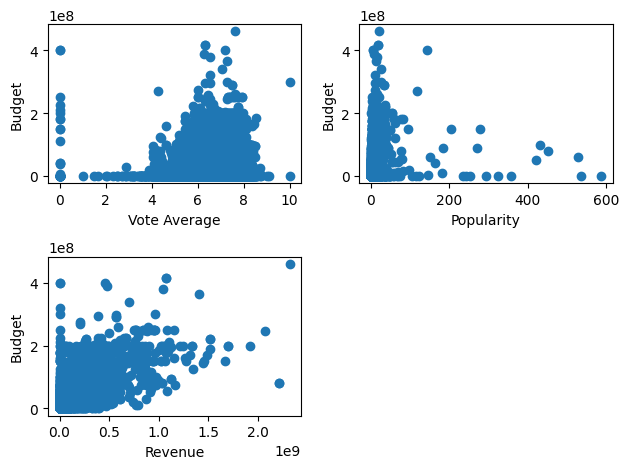

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0][0].scatter(fr_data['vote_average'], fr_data['budget'])
ax[0][0].set_xlabel('Vote Average')
ax[0][0].set_ylabel('Budget')

ax[0][1].scatter(fr_data['popularity'], fr_data['budget'])
ax[0][1].set_xlabel('Popularity')
ax[0][1].set_ylabel('Budget')

ax[1][0].scatter(fr_data['revenue'], fr_data['budget'])
ax[1][0].set_xlabel('Revenue')
ax[1][0].set_ylabel('Budget')

ax[1][1].axis('off')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

For the numerical values, we remove null values. Then, we split the dataset into train & test datasets.

Finally, we normalize the X train dataset, and we use the obtained values of the normalization for the X test dataset.  
We do not need to normalize the y datasets, because they are predicted. 

We also do not filter out the extreme values (outliers), because they are relevant in our study.

In [5]:
filtered_num_df = fr_data[
    (fr_data["revenue"] > 0) & (fr_data["budget"] > 0)
]  # Some movies do not have revenue or budget data
print("filtered df shape: ", filtered_num_df.shape)
numerical_num_df = filtered_num_df[
    ["budget", "vote_average", "revenue", "popularity"]
]  # Extracting numerical columns

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    numerical_num_df[["revenue", "vote_average", "popularity"]],
    numerical_num_df["budget"],
    test_size=0.2,
    random_state=42,
)

num_scaler = StandardScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_test_num_scaled = num_scaler.transform(X_test_num)

X_train_num_scaled

filtered df shape:  (4719, 26)


array([[-0.5687697 ,  0.08987521, -0.18655216],
       [-0.47235884,  1.104772  , -0.22615338],
       [ 1.70138288, -0.02671867,  0.18542752],
       ...,
       [-0.62979439, -1.07208886, -0.25935309],
       [-0.56591946, -0.41624825, -0.24278009],
       [ 1.00672308, -0.24400728,  0.09408265]])

We then display the correlation matrix of the numerical dataset.  

There is low correlation for all features, maybe except between revenue and budget.  
Therefore, we do not need to do feature extraction with PCA. 

<Axes: >

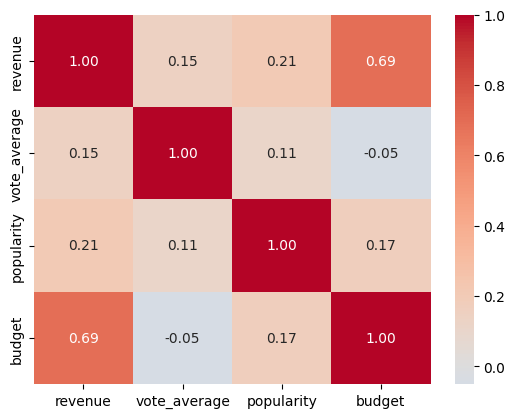

In [6]:
sns.heatmap(numerical_num_df[["revenue", "vote_average", "popularity", "budget"]].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)

### Textual values

For the textual part, we have analyzed it as a multi-labelling problem, which means that a movie's overview can belong to several `genres`.  
This is a multi-label problem, because a movie can be associated with multiple genres. 

Furthermore, we will preprocess the text: convert the text to lowercase, remove punctuation and lemmatize the words.  
We can preprocess before the train & test split, because there is no risk of data leakage.  

In [21]:
df_text = fr_data[['overview', 'genres']]

# Convert genres from a list of dictionaries to a list of strings
df_text.loc[:, 'genres'] = df_text['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Preprocess the overview text
nlp = spacy.load(SPACY_MODEL)
with nlp.select_pipes(disable=[]):  # We use the parser component (syntaxic analysis), tokenization (text -> list), lemmatization (word to most basic form) and NER (unlinkable words) 
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(df_text["overview"], batch_size=50, n_process=-1)):
        # Exclude tokens that are part of a named entity (NER), punctuation, and stop words
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc if not token.ent_type_ and not token.is_punct and not token.is_stop]))
    df_text.loc[:, "overview"] = preprocessed_texts
    
df_text

,overview,genres
0,anthologie animation guerrier féroce histoire ...,"[Animation, Action, Science-Fiction]"
2,cryptographe génial introverti travailler sous...,"[Thriller, Action]"
3,coup grâce journée affreusement pénible pousse...,"[Thriller, Drame, Crime]"
4,doué résoudre problème vieux connaissance tuer...,"[Mystère, Crime, Thriller]"
5,planète comparaître créer l’«expérience 626 cr...,"[Familial, Science-Fiction, Comédie, Aventure]"
...,...,...
9991,bord panique total être voler étrange oiseau n...,"[Animation, Aventure]"
9993,laid barbouille visage guise maquillage aucun ...,[Horreur]
9995,cœur steppe meurtrier guider équipe policier e...,"[Drame, Crime]"
9996,conflit éclater royaume maître allier garde dé...,"[Action, Aventure, Drame, Fantastique, Romance]"


For the classification, the model needs all the target possibilities. Therefore, we will list all the movie genres into one place. 

Classes are the possible categories of the dataset.  
Labels are the actual categories assigned to the data samples. 

In [22]:
all_genres_set = set()
for genres in df_text['genres']:
    all_genres_set.update(genres)
all_genres: list[str] = sorted(list(all_genres_set))
all_genres

['Action',
 'Animation',
 'Aventure',
 'Comédie',
 'Crime',
 'Documentaire',
 'Drame',
 'Familial',
 'Fantastique',
 'Guerre',
 'Histoire',
 'Horreur',
 'Musique',
 'Mystère',
 'Romance',
 'Science-Fiction',
 'Thriller',
 'Téléfilm',
 'Western']

We will train the models with multi-label binarizer, as the teacher recommended. 

It transforms the labels into numbers. 

In [33]:
mlb = MultiLabelBinarizer(classes=all_genres)
y_text = mlb.fit_transform(df_text['genres']) # We embed the target

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    df_text['overview'],
    y_text,
    test_size=0.2,
    random_state=42
)

y_text


array([[1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

When we display the class distribution of the dataset, we can observe it is skewed towards "drama".  
We will need to handle this problem later.  

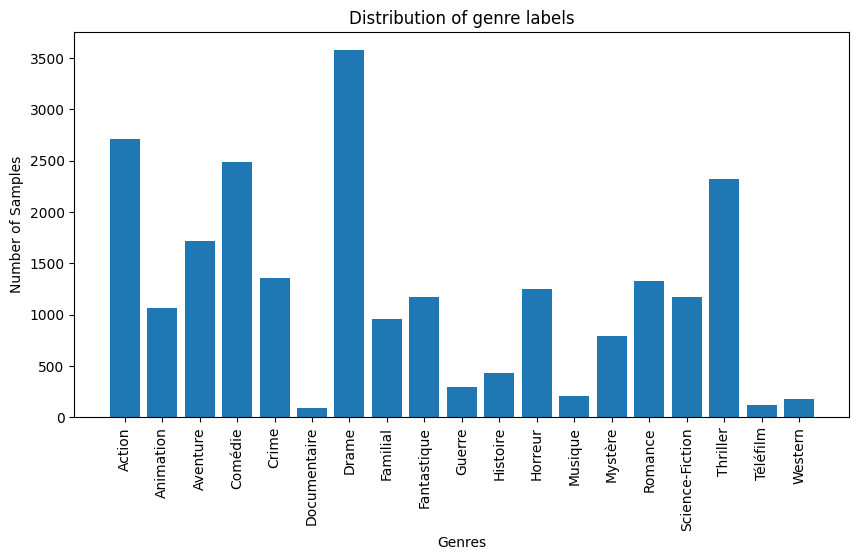

In [34]:
plt.figure(figsize=(10, 5))
plt.bar(all_genres, height=np.sum(y_text, axis=0))
plt.xticks(rotation=90)
plt.title("Distribution of genre labels")
plt.xlabel("Genres")
plt.ylabel("Number of Samples")
plt.show()

Let's display a word cloud for every movie genre.

We may notice that some words have high correlation with their genre:
- "documentaire" word is highly present in "documentaire" genre;
- "soldat" and "guerre" words are overwhelmingly present in data samples with "guerre" genre;
- "musique" with "musique".

Later on, this would definitely help the label prediction. 

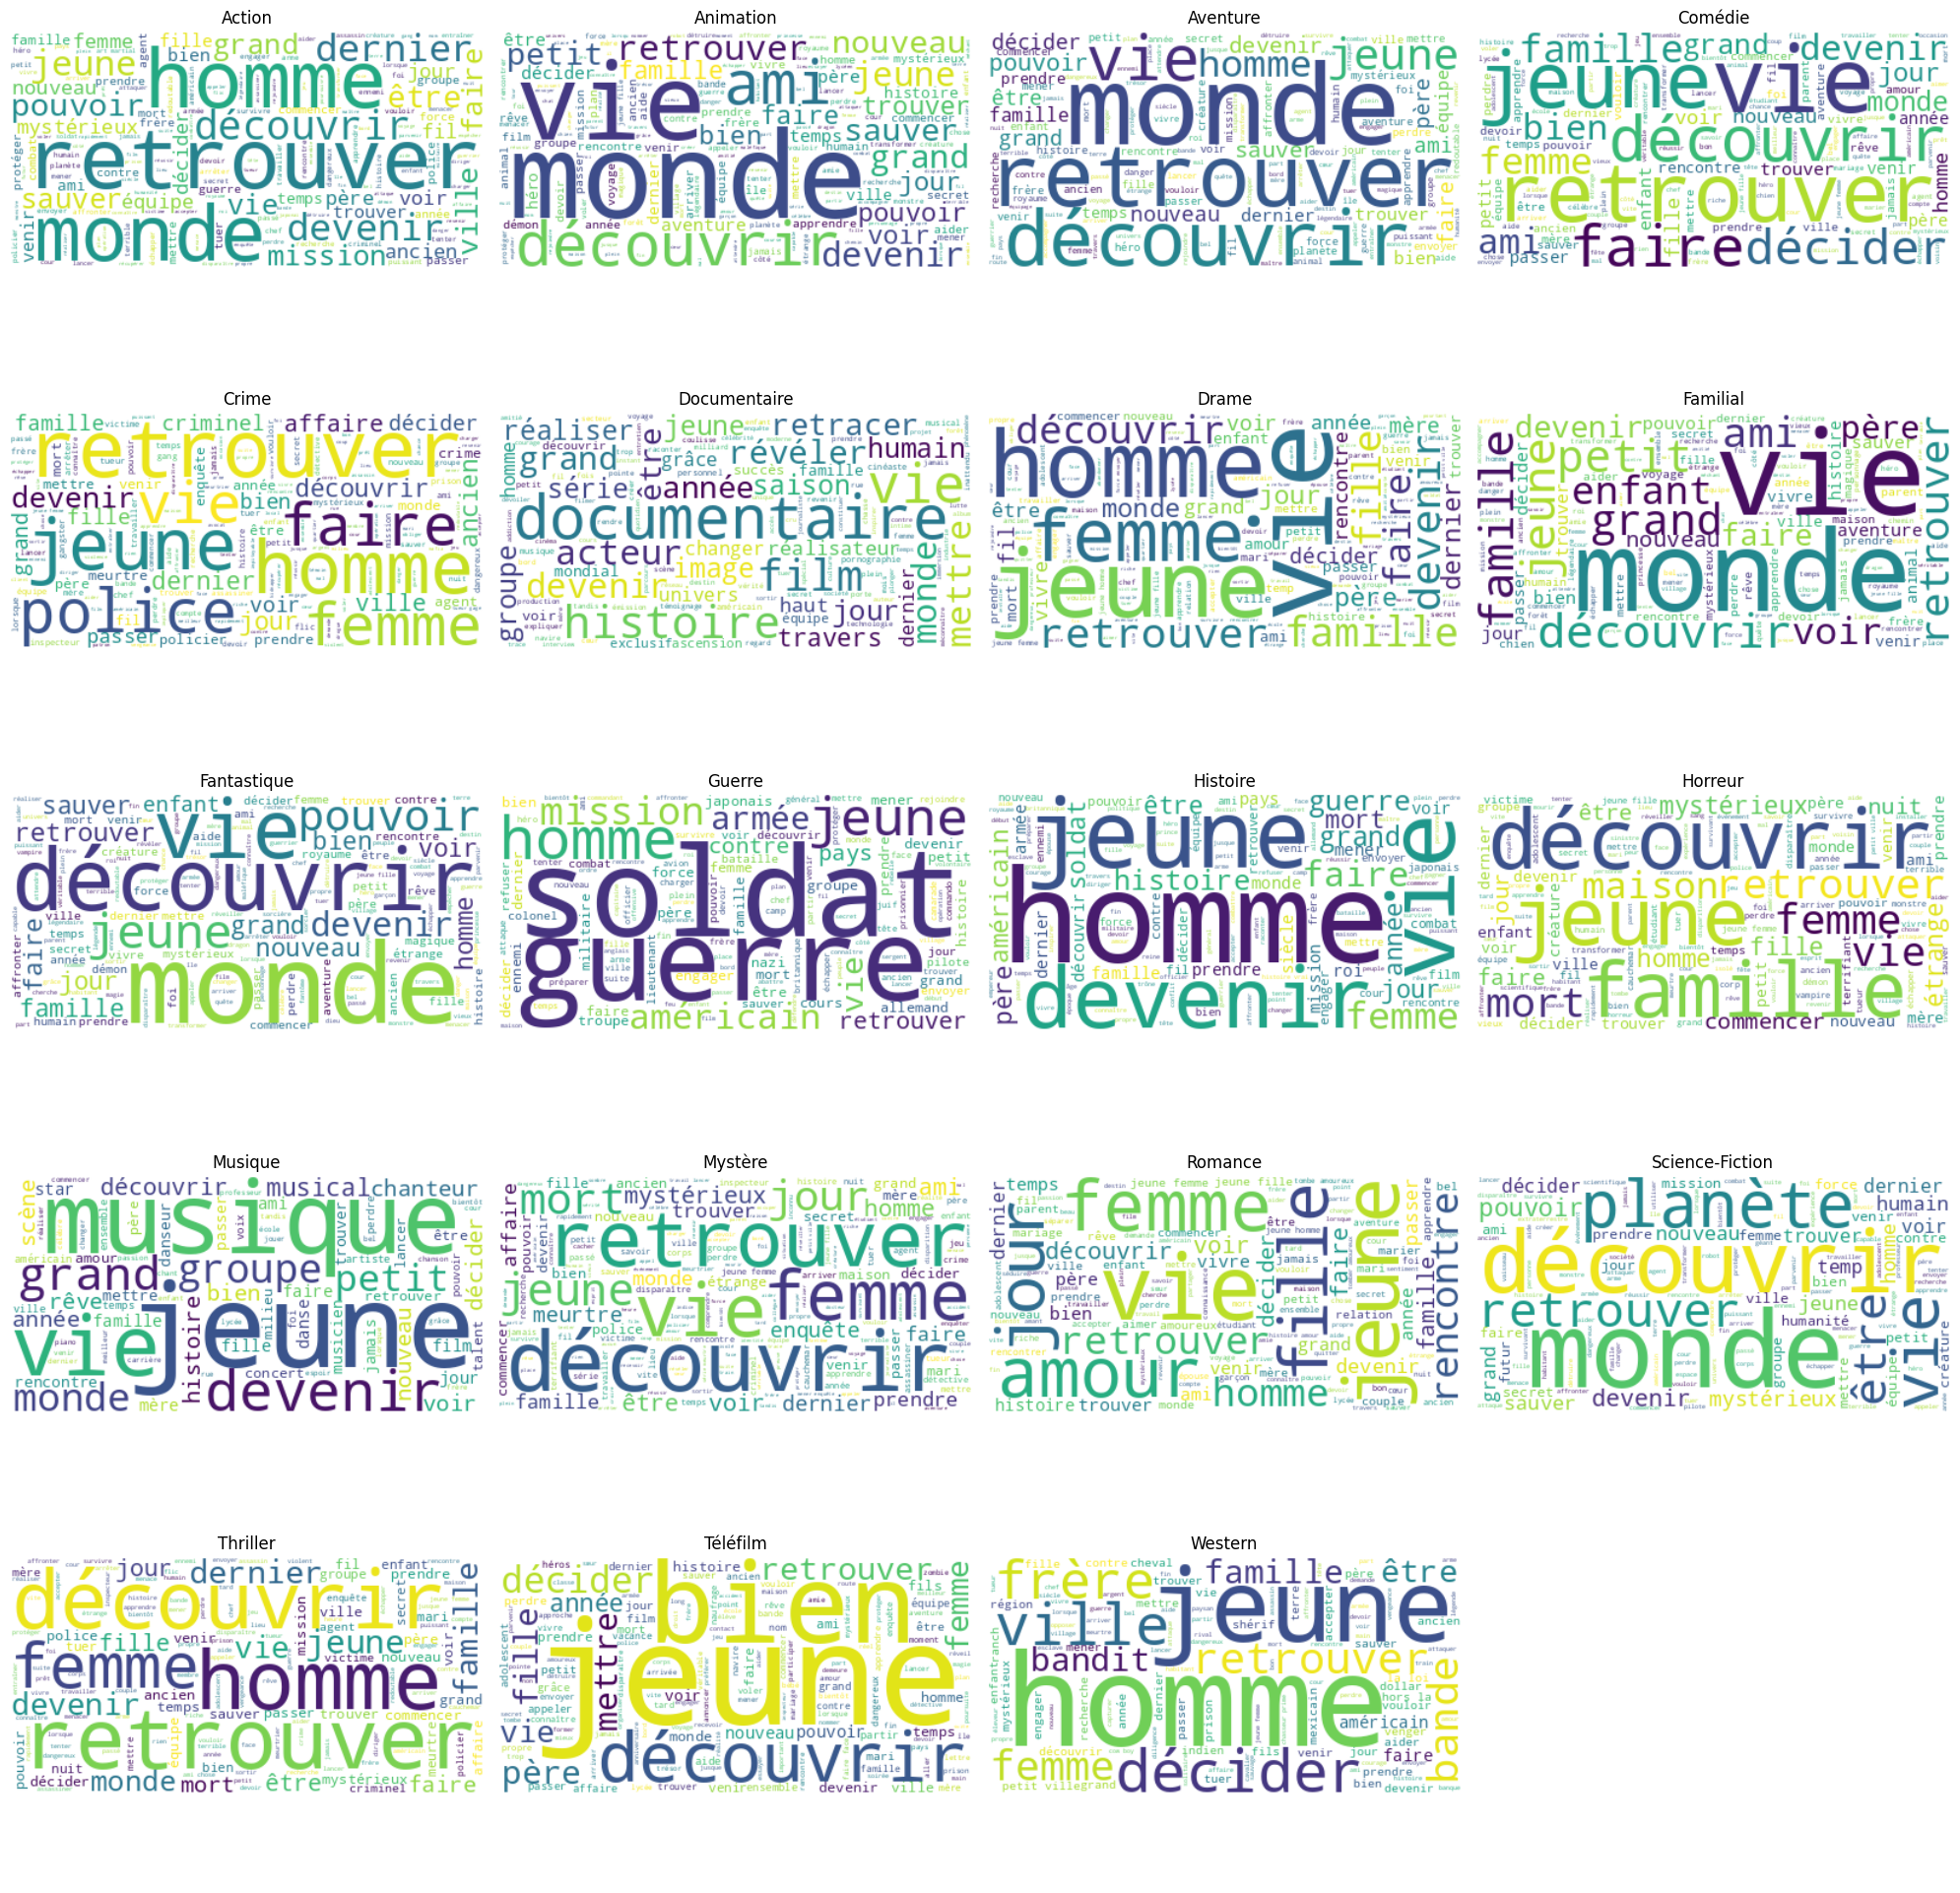

In [ ]:
from wordcloud import WordCloud

def display_wordclouds(n_cols=4):
    n_rows = (len(all_genres) + n_cols - 1) // n_cols
    idx = 0

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for label in all_genres:
        # Get all overviews for this label
        text = " ".join(
            df_text[df_text["genres"].apply(lambda genres: label in genres)]["overview"]
        )
        wordcloud = WordCloud(background_color="white").generate(text)
        axes[idx].imshow(wordcloud, interpolation="bilinear")
        axes[idx].set_title(label)
        axes[idx].axis("off")
        idx += 1

    # Hide any unused subplots
    for j in range(idx, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    
display_wordclouds()

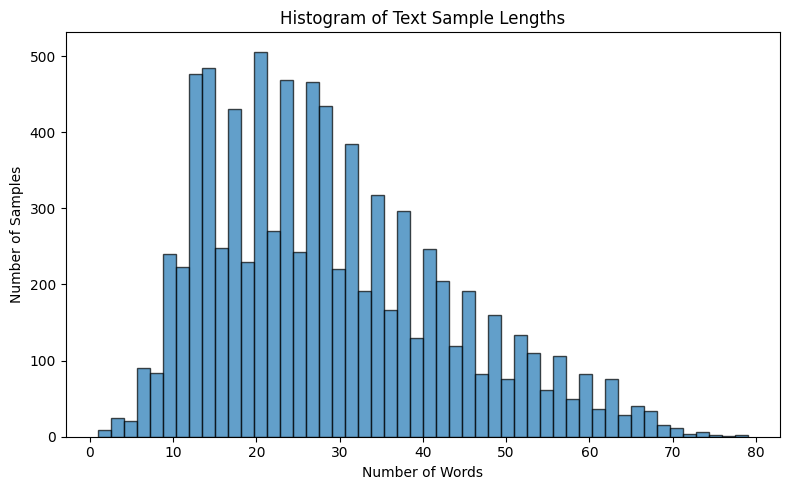

In [70]:
# Calculate the length of each overview in words
plt.figure(figsize=(8, 5))
plt.hist(df_text['overview'].apply(lambda x: len(x.split())), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Histogram of Text Sample Lengths')
plt.tight_layout()
plt.show()

## Implementation of models

### Numerical values 

For the numerical values, we are going to use multiple models: Linear Regression, Decision Tree Regressor, Gradient Boosting Regressor and Random Forest Regressor. 

In [59]:
models = ["Linear Regression", "Decision Tree Regressor", "Gradient Boosting Regressor", "Random Forest Regressor"]
values = []

#### Linear Regression

A simple model that fits a straight line (or hyperplane) to predict a continuous target variable as a linear combination of input features.  
It assumes a linear relationship between features and the target.

In [60]:
lr_model_num = LinearRegression()
lr_model_num.fit(X_train_num_scaled, y_train_num)

y_pred_num = lr_model_num.predict(X_test_num_scaled)

r2 = r2_score(y_test_num, y_pred_num)
values.append(r2)
print("Mean Squared Error:", mean_squared_error(y_test_num, y_pred_num))
print("R² Score:", r2)

Mean Squared Error: 1255624988397302.8
R² Score: 0.4534423373458184


#### Decision Tree Regressor

A model that splits the data into branches based on feature values, creating a tree structure.  
Each leaf node predicts a value.  

It can capture non-linear relationships and is easy to interpret.

In [61]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
regressor.fit(X_train_num_scaled, y_train_num)
y_pred_num_tree = regressor.predict(X_test_num_scaled)

r2 = r2_score(y_test_num, y_pred_num_tree)
values.append(r2)
print("Mean Squared Error of the Decision Tree Regressor:", mean_squared_error(y_test_num, y_pred_num_tree))
print("R² Score:", r2)

Mean Squared Error of the Decision Tree Regressor: 1056810776437410.5
R² Score: 0.5399836470484322


#### Gradient Boosting Regressor

An ensemble method that builds a series of decision trees,  
where each new tree tries to correct the errors of the previous ones. 

It combines the predictions of all trees for a strong, accurate model.

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor(random_state=42)

param_grid = {
    'max_depth': [3, 5, 10, 20, 30, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_num_scaled, y_train_num)

y_pred = grid_search.predict(X_test_num_scaled)

grid_search

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
                         'max_depth': [3, 5, 10, 20, 30, None]},
             scoring='r2', verbose=1)

In [63]:
values.append(grid_search.best_score_)
print("Best R2: ", grid_search.best_score_)
print("Best parameters: ", grid_search.best_params_)

Best R2:  0.5657960787983156
Best parameters:  {'learning_rate': 0.2, 'max_depth': 5}


#### Random Forest Regressor

An ensemble of many decision trees, each trained on a random subset of the data and features.  
The final prediction is the average of all tree predictions. 

It reduces overfitting and improves accuracy compared to a single tree.

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_model_num  = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4] 
}

scoring = 'r2'

grid_search = GridSearchCV(
    estimator=rf_model_num ,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_num_scaled, y_train_num)

print("Best parameters:", grid_search.best_params_)

# grid_search

y_pred_rf_num = grid_search.predict(X_test_num_scaled)

r2 = r2_score(y_test_num, y_pred_rf_num)
values.append(r2)
print("Random Forest Mean Squared Error:", mean_squared_error(y_test_num, y_pred_rf_num))
print("Random Forest R² Score:", r2)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Mean Squared Error: 846121488967221.8
Random Forest R² Score: 0.631694026795625


### Textual values

#### TF-IDF

##### Logistic Regression

Vectorizing the text with TF-IDF, which was the best vectorizer in the second lab 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words=None)
X_train_text_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Display the first 5 rows of the TF-IDF vectors 
X_train_text_tfidf.toarray()[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We will use OneVsRestClassifier to solve our multi-label classification problem.  
This works by training 1 classifier per class which learns to distinguish this class versus all others; and for prediction, for each class, the classifier with the highest score is chosen. 

To handle class imbalance, we also use a "balanced" class weight, which penalizes misclassification of minority genres more.   

In [ ]:
tfidf_model = OneVsRestClassifier(LogisticRegression(class_weight="balanced"))
tfidf_model.fit(X_train_text_tfidf, y_train_text)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))

After fitting the One Vs. Rest classifier, we now can estimate its effectiveness with the test dataset.  
Note that the accuracy score is very low. Indeed, in multi-label classification, for a test sample, the set of its predicted labels must exactly match the corresponding set of its real labels.

In [ ]:

y_pred_tfidf = tfidf_model.predict(tfidf_vectorizer.transform(X_test_text))
print("accuracy: ", accuracy_score(y_test_text, y_pred_tfidf))
print(classification_report(y_test_text, y_pred_tfidf, target_names=mlb.classes_, zero_division=np.nan))

accuracy:  0.11592505854800937
                 precision    recall  f1-score   support

         Action       0.67      0.79      0.73       531
      Animation       0.48      0.62      0.54       230
       Aventure       0.54      0.73      0.62       338
        Comédie       0.58      0.67      0.62       489
          Crime       0.56      0.73      0.63       249
   Documentaire       0.78      0.54      0.64        26
          Drame       0.65      0.71      0.68       669
       Familial       0.47      0.65      0.54       181
    Fantastique       0.59      0.66      0.62       277
         Guerre       0.42      0.67      0.51        45
       Histoire       0.30      0.46      0.36        79
        Horreur       0.59      0.65      0.62       267
        Musique       0.56      0.47      0.51        40
        Mystère       0.36      0.55      0.44       143
        Romance       0.54      0.66      0.59       277
Science-Fiction       0.60      0.70      0.64       239

Example with an invented overview sample

In [43]:
new_overview = pd.DataFrame(["Une ville futuriste où un détective doit résoudre une série de crimes en utilisant une technologie avancée."])

# Preprocess the overview text:
with nlp.select_pipes(disable=[]):
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(new_overview[0], batch_size=50, n_process=-1)):
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc if not token.ent_type_ and not token.is_punct and not token.is_stop]))
    new_overview.loc[:0] = preprocessed_texts

X_new = tfidf_vectorizer.transform(new_overview[0])
y_new = tfidf_model.predict(X_new)
print("Predicted genres:", mlb.inverse_transform(y_new))

Predicted genres: [('Action', 'Crime', 'Mystère', 'Science-Fiction', 'Thriller')]


##### Naive Bayes on TF-IDF

Naive Bayes on BERT unapplicable because of negative values.

#### BERT Embeddings

In [ ]:
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(current_device)
model.eval()  # Set model to evaluation mode
def get_embeddings(texts, tokenizer, model, batch_size=16, device=current_device):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Example: get embeddings for train and test sets
X_train_embeddings = get_embeddings(X_train_text.tolist(), tokenizer, model)
X_test_embeddings = get_embeddings(X_test_text.tolist(), tokenizer, model)

In [45]:
# Train logistic regression
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight="balanced"))
clf.fit(X_train_embeddings, y_train_text)

# Predict
y_pred_bert = clf.predict(X_test_embeddings)

In [46]:
print(classification_report(y_test_text, y_pred_bert, target_names=mlb.classes_, zero_division=np.nan))

                 precision    recall  f1-score   support

         Action       0.56      0.70      0.62       531
      Animation       0.30      0.68      0.42       230
       Aventure       0.39      0.70      0.50       338
        Comédie       0.44      0.66      0.53       489
          Crime       0.38      0.70      0.49       249
   Documentaire       0.23      0.54      0.33        26
          Drame       0.55      0.65      0.60       669
       Familial       0.27      0.72      0.39       181
    Fantastique       0.33      0.63      0.43       277
         Guerre       0.21      0.69      0.33        45
       Histoire       0.17      0.63      0.27        79
        Horreur       0.35      0.64      0.45       267
        Musique       0.21      0.57      0.30        40
        Mystère       0.19      0.61      0.29       143
        Romance       0.35      0.67      0.46       277
Science-Fiction       0.38      0.73      0.50       239
       Thriller       0.44    

## Conclusion

### Comparison of models

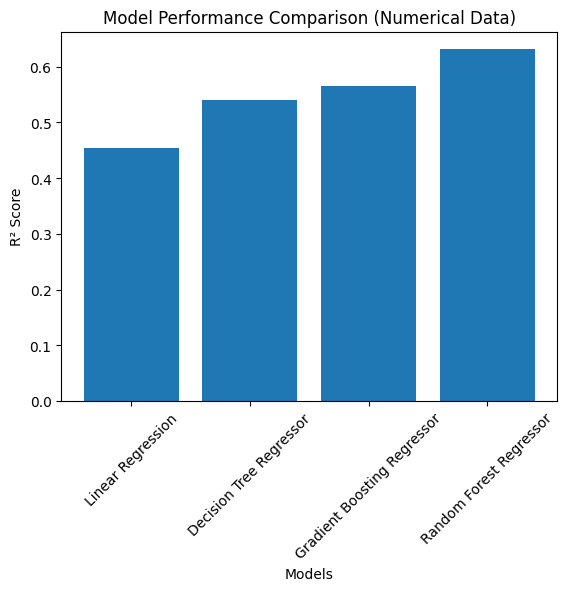

In [65]:
plt.bar(models, values)
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (Numerical Data)')
plt.show()

As we can see above, the Random Forest model is better than the others for different reasons:
- Random Forest trains a set of decision trees with different subsets -> avoid overfitting
- Random Forest captures non-linear problem (real life problem are never perfectly linear)
- Random Forest computes the variance by the average of all the small trees (Decision Tree might has a huge variance) -> more stable

### Business recommendations

Based on the overall results we have obtained, we can answer the questions we asked ourselves at the start of the report. 
> Is money strong enough to determine profitability, popularity and public appreciation of movies?  

No. Profitability, popularity and public appreciation of movies do not cause budget requirements, nor do they correlate the latter. 

We think that passion and luck determine these three elements significantly more. 

> Are movies so plain that one may guess their genres with only their overview? 

Yes, but no.  

Yes, because it seems like movie overviews offer enough information to guess the movie genres accurately.  
No, because most movies are not plain. 